In [1]:
!pip install d2l


In [2]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

- `layer.__class`得到的是`layer`对象所属的类，`__name__`得到对应的名字

In [3]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__, 'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


## 训练模型

In [4]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.6MB/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 229kB/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 4.21MB/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 17.9MB/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


- `evaluate_accuracy_gpu`就是多了一步GPU（指定的`device`）上运行
- 需要**先将数据传输到`device`**

In [5]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
  if isinstance(net, nn.Module):
    net.eval()
    if not device:
      device = next(iter(net.parameters())).device
  metric = d2l.Accumulator(2)
  with torch.no_grad():
    for X, y in data_iter:
      if isinstance(X, list):
        X = [x.to(device) for x in X]
      else:
        X = X.to(device)
      y = y.to(device)
      metric.add(d2l.accuracy(net(X), y), y.numel())
  return metric[0] / metric[1]

In [6]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
  # 先初始化参数
  def init_weights(m):
    if type(m) == nn.Linear or isinstance(m, nn.Conv2d):
      nn.init.xavier_normal_(m.weight)
  net.apply(init_weights)

  # 选好设备，网络移到设备上
  print('training on {deivce}')
  net.to(device)

  optimizer = torch.optim.SGD(net.parameters(), lr=lr)
  loss = nn.CrossEntropyLoss()
  animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
               legend=['train loss', 'train acc', 'test acc'])
  timer, num_batches = d2l.Timer(), len(train_iter)

  for epoch in range(num_epochs):
    metric = d2l.Accumulator(3)
    net.train()
    for i, (X, y) in enumerate(train_iter):
      timer.start()
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)
      y_hat = net(X)
      l = loss(y_hat, y)
      l.backward()
      optimizer.step()
      with torch.no_grad():
        metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
      timer.stop()
      train_l = metric[0] / metric[2]
      train_acc = metric[1] / metric[2]
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches,(train_l, train_acc, None))
    test_acc = evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch + 1, (None, None, test_acc))
  print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, test acc {test_acc:.3f}')
  print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(device)}')

loss 0.460, train acc 0.826, test acc 0.809
39807.5 examples/sec on cuda:0


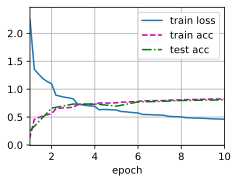

In [ ]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.303, train acc 0.887, test acc 0.852
3236.9 examples/sec on cpu


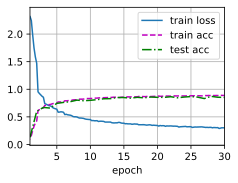

In [7]:
lr, num_epochs = 0.9, 30
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

- **`ctrl + M + L`显示行数**

## 练习

1. 将平均池化层替换为最大池化层，会发生什么？
  - 在训练集和测试集上均取得了**更好的结果**

loss 0.393, train acc 0.856, test acc 0.850
36877.3 examples/sec on cuda:0


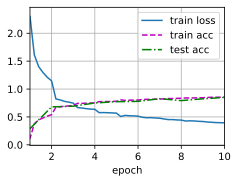

In [ ]:
net = nn.Sequential(
  nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
  nn.MaxPool2d(kernel_size=2, stride=2),
  nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
  nn.MaxPool2d(kernel_size=2, stride=2),
  nn.Flatten(),
  nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
  nn.Linear(120, 84), nn.Sigmoid(),
  nn.Linear(84, 10)
)

train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

2. 尝试构建一个基于LeNet的更复杂的网络，以提高其准确性
 - 调整卷积窗口大小
 - 调整输出通道的数量
 - 调整激活函数
 - 调整卷积层的数量
 - 调整全连接层的数量
 - 调整学习率和其他训练细节（例如，初始化和轮数）

- 就是进行一些调整，得以得到相应的结果变化


loss 0.437, train acc 0.837, test acc 0.835
39709.1 examples/sec on cuda:0


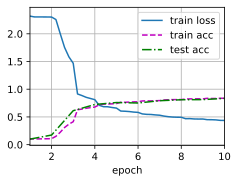

In [ ]:
net = nn.Sequential(
  nn.Conv2d(1, 6, kernel_size=3, padding=2), nn.Sigmoid(),
  nn.MaxPool2d(kernel_size=2, stride=2),
  nn.Conv2d(6, 16, kernel_size=4), nn.Sigmoid(),
  nn.MaxPool2d(kernel_size=2, stride=2),
  nn.Flatten(),
  nn.Linear(16 * 6 * 6, 120), nn.Sigmoid(),
  nn.Linear(120, 84), nn.Sigmoid(),
  nn.Linear(84, 10)
)

train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

- `learning_rate`太高，调低再尝试

loss 0.291, train acc 0.892, test acc 0.877
3053.4 examples/sec on cpu


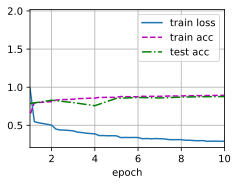

In [ ]:
net = nn.Sequential(
  nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
  nn.MaxPool2d(kernel_size=2, stride=2),
  nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
  nn.MaxPool2d(kernel_size=2, stride=2),
  nn.Flatten(),
  nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
  nn.Linear(120, 84), nn.ReLU(),
  nn.Linear(84, 10)
)

lr = 0.1
num_epochs = 10

train_ch6(net, train_iter, test_iter, num_epochs, lr, torch.device('cpu')) # d2l.try_gpu())

3. 在MNIST数据集上尝试

In [ ]:
net_improve = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=3, padding=2), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 10, kernel_size=3), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(10, 16, kernel_size=3), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 2 * 2, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 20), nn.ReLU(),
    nn.Linear(20, 10))

X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net_improve:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 30, 30])
ReLU output shape: 	 torch.Size([1, 6, 30, 30])
AvgPool2d output shape: 	 torch.Size([1, 6, 15, 15])
Conv2d output shape: 	 torch.Size([1, 10, 13, 13])
ReLU output shape: 	 torch.Size([1, 10, 13, 13])
AvgPool2d output shape: 	 torch.Size([1, 10, 6, 6])
Conv2d output shape: 	 torch.Size([1, 16, 4, 4])
ReLU output shape: 	 torch.Size([1, 16, 4, 4])
AvgPool2d output shape: 	 torch.Size([1, 16, 2, 2])
Flatten output shape: 	 torch.Size([1, 64])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
ReLU output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 20])
ReLU output shape: 	 torch.Size([1, 20])
Linear output shape: 	 torch.Size([1, 10])


loss 0.266, train acc 0.900, test acc 0.880
26431.7 examples/sec on cuda:0


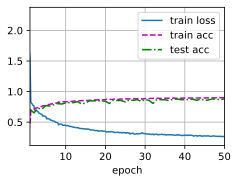

In [ ]:
lr, num_epochs = 0.1, 50
train_ch6(net_improve, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

4. 显示不同输入时， LeNet第一层和第二层的激活值
- `x_first_Sigmoid_layer = net[0:2](X)[0:9, 1, :, :]`:
  - 首先得到的是第一个卷积层和激活函数的输出，**形状为`(batch_size, num_channels, height, width)`**
  - 取输出的**前9个样本**，只取每个样本的**第二个通道**，并且是**整个空间维度**
- `x_first_Sigmoid_layer.reshape(9, 28, 28).cpu().detach()`注意相应的操作


In [ ]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
  """用GPU训练模型(在第六章定义)"""
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
  net.apply(init_weights)
  print('training on', device)
  net.to(device)
  optimizer = torch.optim.SGD(net.parameters(), lr=lr)
  loss = nn.CrossEntropyLoss()
  animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                          legend=['train loss', 'train acc', 'test acc'])
  timer, num_batches = d2l.Timer(), len(train_iter)
  for epoch in range(num_epochs):
    # 训练损失之和，训练准确率之和，样本数
    metric = d2l.Accumulator(3)
    net.train()
    for i, (X, y) in enumerate(train_iter):
      timer.start()
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)
      y_hat = net(X)
      l = loss(y_hat, y)
      l.backward()
      optimizer.step()
      with torch.no_grad():
          metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
      timer.stop()
      train_l = metric[0] / metric[2]
      train_acc = metric[1] / metric[2]
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
          animator.add(epoch + (i + 1) / num_batches,
                        (train_l, train_acc, None))
    test_acc = evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch + 1, (None, None, test_acc))
  x_first_Sigmoid_layer = net[0:2](X)[0:9, 1, :, :]
  d2l.show_images(x_first_Sigmoid_layer.reshape(9, 28, 28).cpu().detach(), 1, 9)
  x_second_Sigmoid_layer = net[0:5](X)[0:9, 1, :, :]
  d2l.show_images(x_second_Sigmoid_layer.reshape(9, 10, 10).cpu().detach(), 1, 9)
  print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
  print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.465, train acc 0.825, test acc 0.817
38106.3 examples/sec on cuda:0


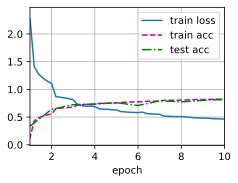

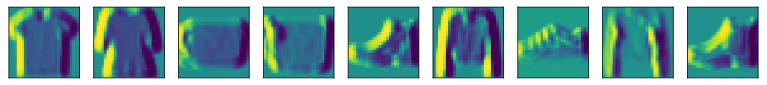

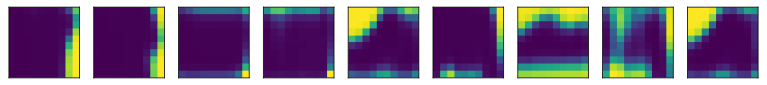

In [ ]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 注意
- 高宽减半-通道数翻倍（像素减少，但每个像素包含的信息增加了）
